In [1]:
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from statistics import mean

sns.set()

The alpha-beta filter can be considered as a modification of the Kalman filter. Thus, this filter, like the Kalman filter, only works if the noises follow a normal distribution. However, in reality, noises often correspond to the Cauchy distribution, which is similar to the Gaussian distribution but has much heavier tails.

## Normal Distribution
The normal distribution (Gaussian distribution) has the following probability density function: \
$$
f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$
<div style="text-align: left;">
$x$ - random variable <br>
$\mu$ - mean (average) <br>
$\sigma$ - standard deviation <br>
</div>

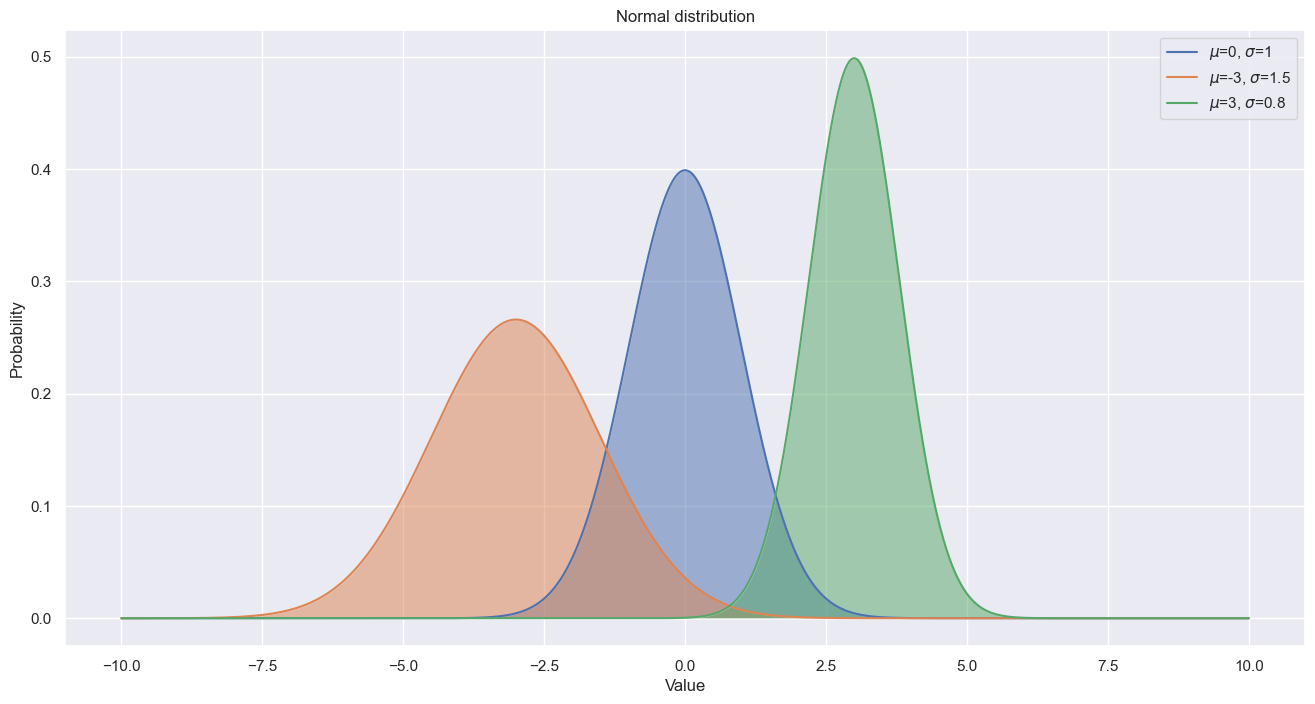

In [13]:
plt.figure(figsize=(16,8))
plt.title('Normal distribution')
plt.xlabel('Value')
plt.ylabel('Probability')


def plot_normal_distribution(mu, sigma, left, right, size):
    x = np.linspace(left, right, size)
    y = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-(x-mu)**2 / (2*sigma**2))
    label = '$\mu$=' + str(mu) + ', $\sigma$=' + str(sigma)
    plt.plot(x, y, label=label)
    plt.fill_between(x, 0, y, alpha=0.5)


plot_normal_distribution(mu=0, sigma=1, left=-10, right=+10, size=100000)
plot_normal_distribution(mu=-3, sigma=1.5, left=-10, right=+10, size=100000)
plot_normal_distribution(mu=3, sigma=0.8, left=-10, right=+10, size=100000)

plt.legend()
plt.show()

## Cauchy distribution
The Cauchy distribution has the following probability density function:
$$
f(x) = \frac{1}{\pi \gamma \left[ 1 + \left( \frac{x - x_0}{\gamma} \right)^2 \right]}
$$
where:
$x$ - random variable </br>
$x_0$ - median (position of the distribution peak) </br>
$\gamma$ - scale parameter (width of the distribution) </br>


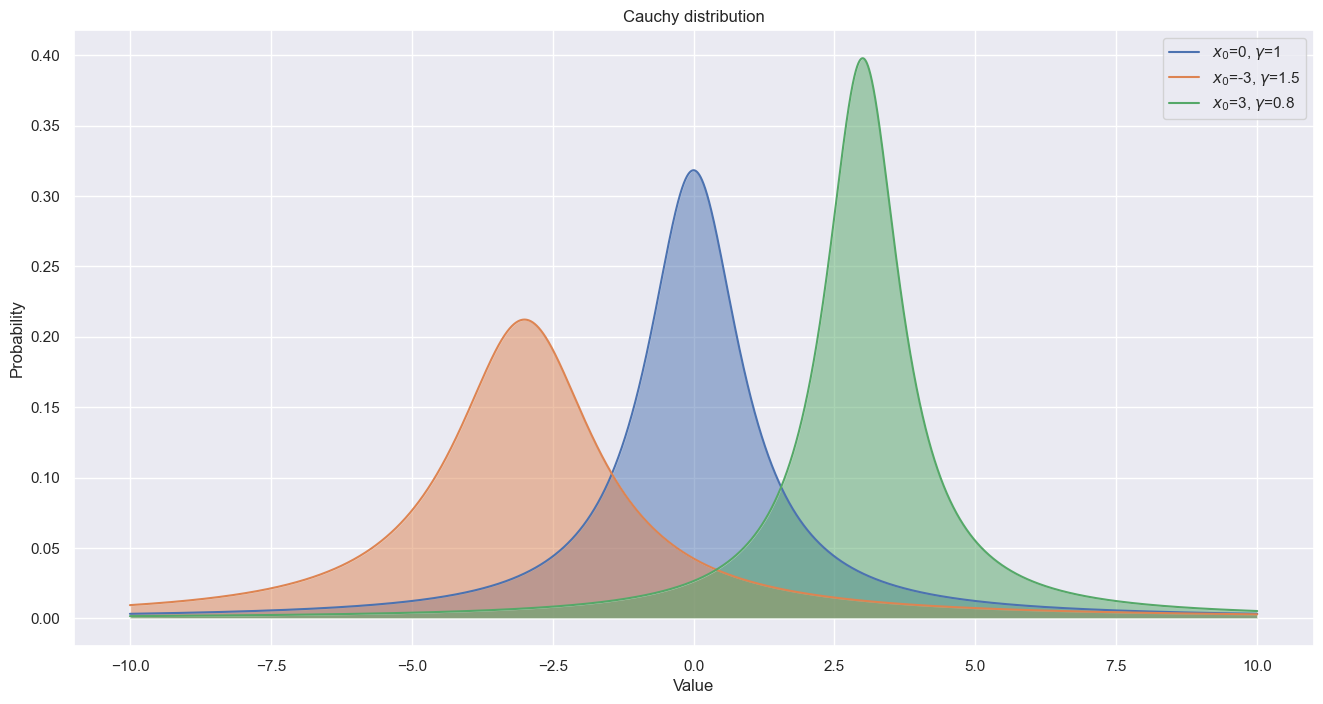

In [14]:
plt.figure(figsize=(16,8))
plt.title('Cauchy distribution')
plt.xlabel('Value')
plt.ylabel('Probability')


def plot_cauchy_distribution(x0, gamma, left, right, size):
    x = np.linspace(left, right, size)
    y = (1/(np.pi * gamma * (1 + ((x - x0)/gamma)**2)))
    label = '$x_0$=' + str(x0) + ', $\gamma$=' + str(gamma)
    plt.plot(x, y, label=label)
    plt.fill_between(x, 0, y, alpha=0.5)


plot_cauchy_distribution(x0=0,  gamma=1,  left=-10, right=+10, size=100000)
plot_cauchy_distribution(x0=-3, gamma=1.5, left=-10, right=+10, size=100000)
plot_cauchy_distribution(x0=3,  gamma=0.8, left=-10, right=+10, size=100000)

plt.legend()
plt.show()

## Comparison of filter performance

In [4]:
# This is the parameter that regulates the maximum confidence of the filter model
MAX_STEPS = 5

def filter_step(k, meas, dt, x_prev, V_prev):
    if (x_prev is None) and (V_prev is None): # first step of initialization
        return meas, None
    
    if V_prev is None:                        # second step of initialization
        return meas, (meas - x_prev) / dt

    if k > MAX_STEPS:
        k = MAX_STEPS
    
    a = 2.*(2. * k - 1.) / (k * (k + 1.))
    b = 6. / (k * (k + 1.))

    x_pred = x_prev + (V_prev*dt)
    V_pred = V_prev
    
    x = x_pred + (a * (meas - x_pred))
    V = V_pred + ((b / dt) * (meas - x_pred))
    
    return x, V

In [ ]:
num_steps = 50
x0 = 50.
V0 = 25.
dt = 1.
true_cv  = []

for i in range(number_steps):
    t = i * dt    
    true_cv.append(x0 + (V0*t))


plt.figure(figsize=(16,8))
plt.title('Constant Velocity Model')
plt.xlabel('t [secs]')
plt.ylabel('x [m]')


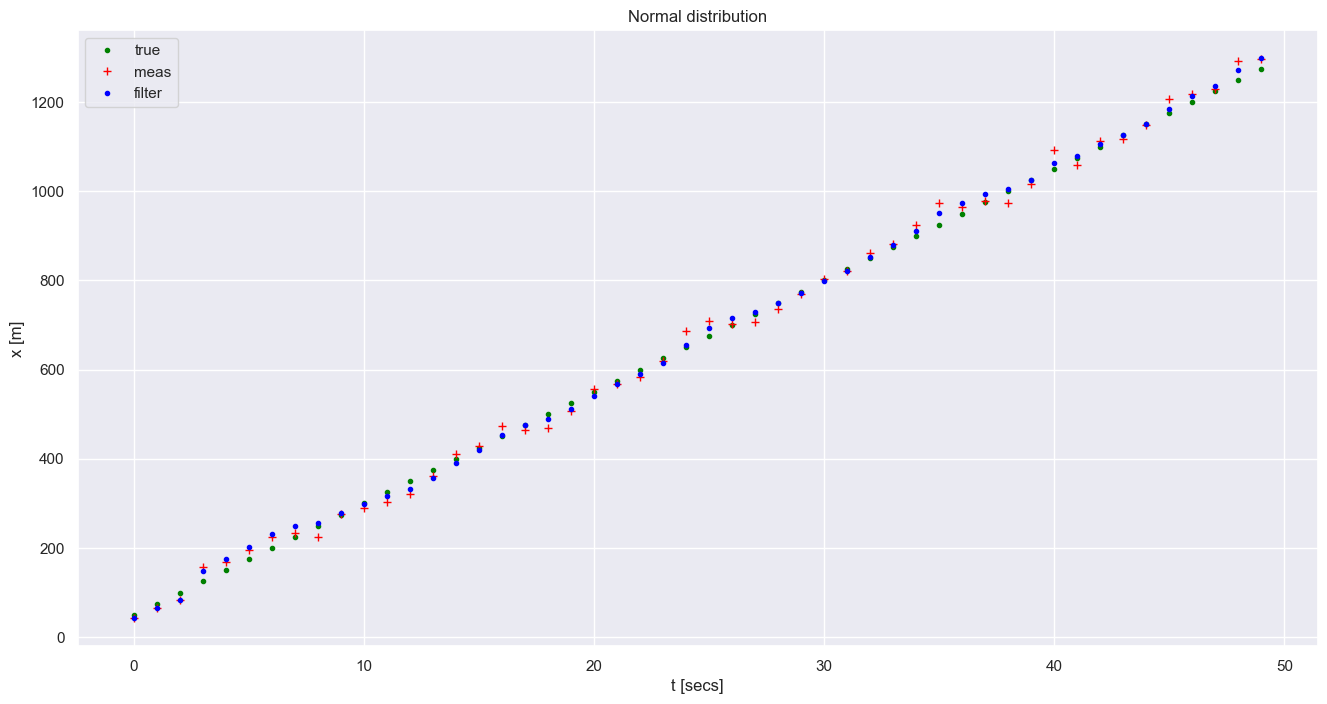

In [5]:
mu = 0.
std = 20.
gaussian_noise = np.random.normal(mu, std, number_steps)

meas_arr = true_arr + gaussian_noise

x_arr = []
V_arr = []
x_prev = None
V_prev = None
for i in range(number_steps):
    x, V = filter_step(i, 10, meas_arr[i], dt, x_prev, V_prev)
    
    x_arr.append(x)
    V_arr.append(V)
    
    x_prev = x
    V_prev = V

plt.figure(figsize=(16,8))
plt.title('Normal distribution')
plt.xlabel('t [secs]')
plt.ylabel('x [m]')
plt.plot(true_arr, marker='.', linestyle='none', color='green', label='true'  ) 
plt.plot(meas_arr, marker='+', linestyle='none', color='red',   label='meas'  ) 
plt.plot(x_arr,    marker='.', linestyle='none', color='blue',  label='filter')
plt.legend(loc='upper left')
plt.show()

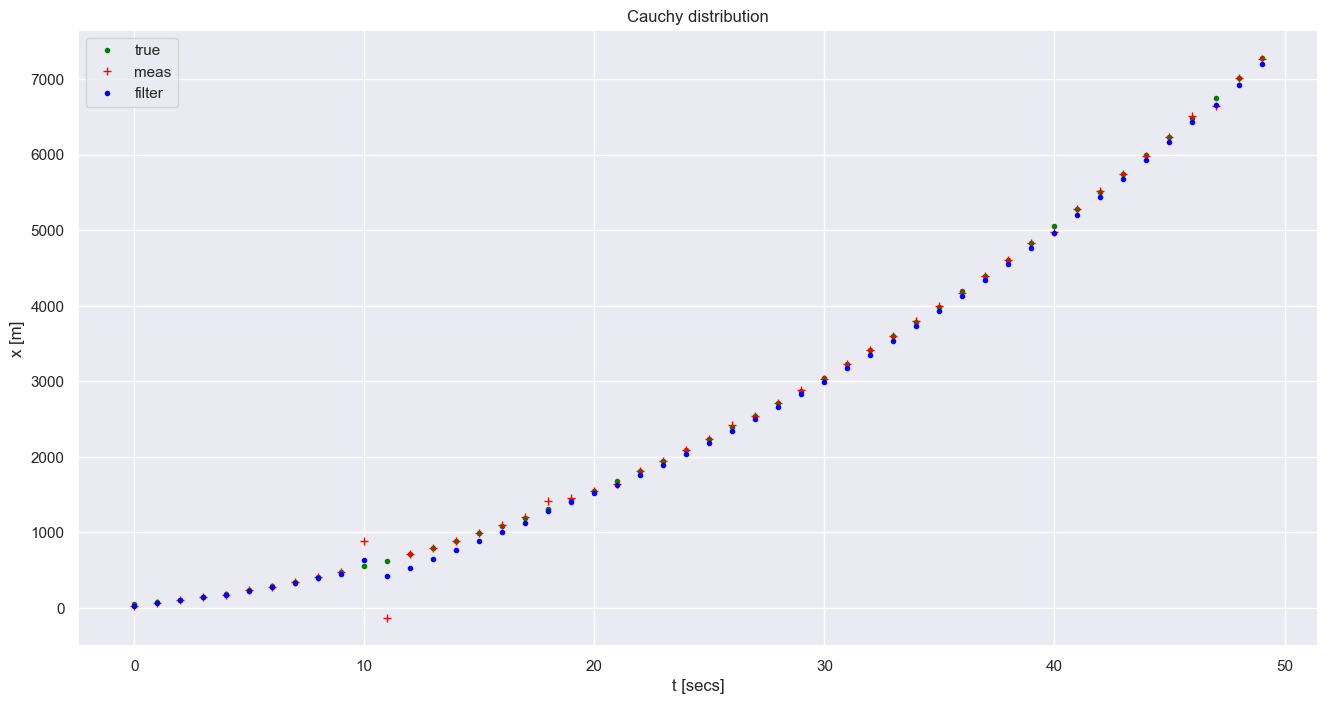

In [10]:
x0 = 0
gamma = 5.
cauchy_noise = sp.stats.cauchy.rvs(x0, gamma, number_steps)
meas_arr = true_arr + cauchy_noise

x_arr = []
V_arr = []
x_prev = None
V_prev = None
for i in range(number_steps):
    x, V = filter_step(i, 10, meas_arr[i], dt, x_prev, V_prev)
    
    x_arr.append(x)
    V_arr.append(V)
    
    x_prev = x
    V_prev = V
    
plt.figure(figsize=(16,8))
plt.title('Cauchy distribution')
plt.xlabel('t [secs]')
plt.ylabel('x [m]')
plt.plot(true_arr, marker='.', linestyle='none', color='green', label='true'  ) 
plt.plot(meas_arr, marker='+', linestyle='none', color='red',   label='meas'  ) 
plt.plot(x_arr,    marker='.', linestyle='none', color='blue',  label='filter')
plt.legend(loc='upper left')
plt.show()

In [8]:
W_SIZE_TO_DETECT_OUTLIERS = 5
MAX_W_SIZE = 50

# this version of the filter takes emissions into account
def filter_step_2(k, k_max, meas, dt, x_prev, V_prev, w_arr):
    if (x_prev is None) and (V_prev is None): # first step of initialization
        return meas, None, w_arr
    
    if V_prev is None:                        # second step of initialization
        return meas, (meas - x_prev) / dt, w_arr

    if k > k_max:
        k = k_max
    
    a = 2.*(2. * k - 1.) / (k * (k + 1.))
    b = 6. / (k * (k + 1.))

    x_pred = x_prev + (V_prev*dt)
    V_pred = V_prev
    w = (meas - x_pred)
    
    if (len(w_arr) > W_SIZE_TO_DETECT_OUTLIERS) and (w > (3. * mean(w_arr))):
        x = x_pred
        V = V_pred
        return x, V, w_arr
    
    x = x_pred + (a * w)
    V = V_pred + ((b / dt) * w)

    if len(w_arr) < MAX_W_SIZE:
        w_arr.append(abs(w))
    
    return x, V, w_arr

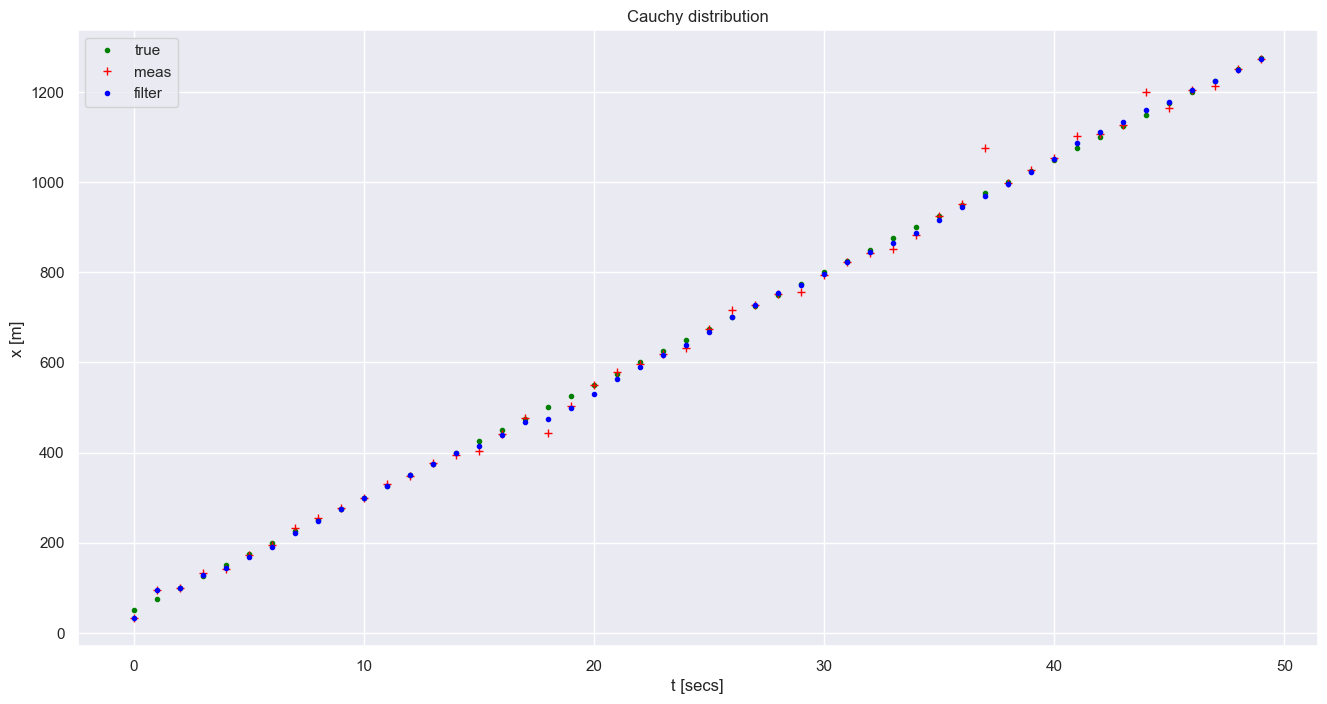

In [25]:
x0 = 0
gamma = 5.
cauchy_noise = sp.stats.cauchy.rvs(x0, gamma, number_steps)
meas_arr = true_arr + cauchy_noise

x_arr = []
V_arr = []
w_arr = []
x_prev = None
V_prev = None
for i in range(number_steps):
    x, V, w_arr = filter_step_2(i, 10, meas_arr[i], dt, x_prev, V_prev, w_arr)
    
    x_arr.append(x)
    V_arr.append(V)
    
    x_prev = x
    V_prev = V
    
plt.figure(figsize=(16,8))
plt.title('Cauchy distribution')
plt.xlabel('t [secs]')
plt.ylabel('x [m]')
plt.plot(true_arr, marker='.', linestyle='none', color='green', label='true'  ) 
plt.plot(meas_arr, marker='+', linestyle='none', color='red',   label='meas'  ) 
plt.plot(x_arr,    marker='.', linestyle='none', color='blue',  label='filter')
plt.legend(loc='upper left')
plt.show()

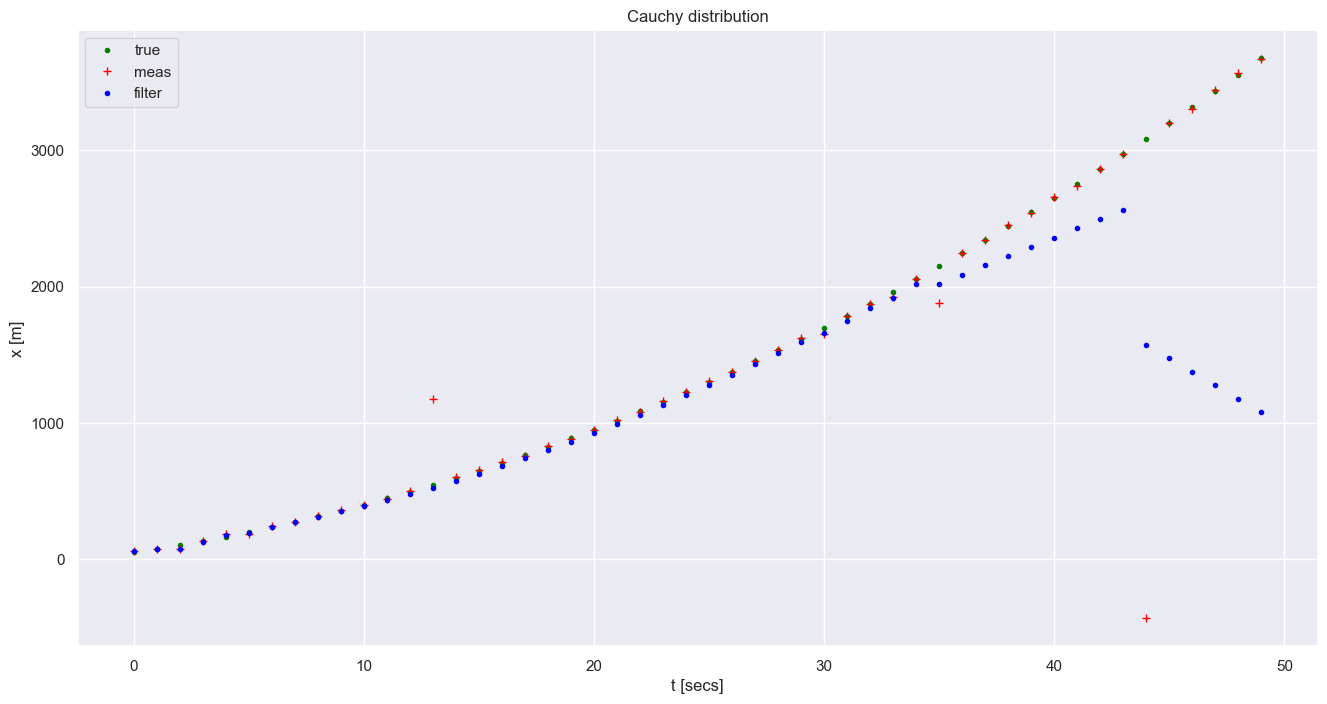

In [12]:
true_arr = []
a = 2.
for i in range(number_steps):
    t = i * dt
    true = x0 + (V0*t) + (a*(t**2)/2.)
    true_arr.append(true)

x0 = 0
gamma = 5.
cauchy_noise = sp.stats.cauchy.rvs(x0, gamma, number_steps)
meas_arr = true_arr + cauchy_noise

x_arr = []
V_arr = []
w_arr = []
x_prev = None
V_prev = None
for i in range(number_steps):
    x, V, w_arr = filter_step_2(i, 10, meas_arr[i], dt, x_prev, V_prev, w_arr)
    
    x_arr.append(x)
    V_arr.append(V)
    
    x_prev = x
    V_prev = V
    
plt.figure(figsize=(16,8))
plt.title('Cauchy distribution')
plt.xlabel('t [secs]')
plt.ylabel('x [m]')
plt.plot(true_arr, marker='.', linestyle='none', color='green', label='true'  ) 
plt.plot(meas_arr, marker='+', linestyle='none', color='red',   label='meas'  ) 
plt.plot(x_arr,    marker='.', linestyle='none', color='blue',  label='filter')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# These are the parameters for eliminating measurement outliers
W_SIZE_TO_DETECT_OUTLIERS = 5
MAX_W_SIZE = 50

# These are the parameters for eliminating measurement outliers
MAX_NUMBER_OUTLIERS = 2
STEP_AFTER_OUTLIERS_IN_A_ROW = 2

# this version of the filter takes into account outliers and possible inconsistency of the motion model
def filter_step_3(k, k_max, meas, dt, x_prev, V_prev, w_arr):
    if (x_prev is None) and (V_prev is None): # first step of initialization
        return meas, None, w_arr
    
    if V_prev is None:                        # second step of initialization
        return meas, (meas - x_prev) / dt, k, w_arr

    if k > k_max:
        k = k_max
    
    a = 2.*(2. * k - 1.) / (k * (k + 1.))
    b = 6. / (k * (k + 1.))

    x_pred = x_prev + (V_prev*dt)
    V_pred = V_prev
    w = (meas - x_pred)
    
    if (len(w_arr) > W_SIZE_TO_DETECT_OUTLIERS) and (w > (3. * mean(w_arr))):
        x = x_pred
        V = V_pred
        return x, V, k, w_arr
    
    x = x_pred + (a * w)
    V = V_pred + ((b / dt) * w)

    if len(w_arr) < MAX_W_SIZE:
        w_arr.append(abs(w))
    
    return x, V, k, w_arr